<h1 style='text-align: center;'>Neural Networks Project - Gesture Recognition</h1>

### Introduction:  
<div align="justify">This notebook contains the code to build a project, which aim to develop a gesture recognition feature for smart televisions using deep learning techniques. The task involves recognizing five different gestures performed by users in front of a webcam, each corresponding to a specific command: thumbs up, thumbs down, right swipe, left swipe, stop (pause). This feature will enable users to control the TV without using a remote. </div>

### Problem Statement:  
<div align="justify">
The task involves training a model on a dataset of videos, where each video contains a sequence of 30 frames/images. The dataset is divided into training and validation sets, with each video categorized into one of the five gesture classes. The main aim is to develop a model that performs well on both the training and validation sets, with the ultimate goal of achieving good performance on an unseen test set. </div>

### Objectives:  
<div align="justify">The main objective is to build a gesture recognition feature in the smart-TV using deep learning techniques that can recognise five different gestures performed by the user which will help users control the TV without using a remote . </div>

### Dataset Description:


- The dataset is provided in a zip file containing 'train' and 'val' folders, each with corresponding CSV files.</br>
- Videos are organized into subfolders within the 'train' and 'val' directories, with each subfolder representing a video of a particular gesture.</br>
- Each row in the CSV files contains information about a video, including the name of the subfolder (containing the 30 images), the gesture name, and the numeric label (0-4) of the video.</br>
- Videos may have different dimensions, either 360x360 or 120x160, depending on the webcam used for recording.

In [1]:
## Checking the GPU configuration:

#!nvidia-smi

In [2]:
# Importing necessary libraries:
# For numerical operations:
import numpy as np
# For interacting with the operating system:  
import os
# For image processing:  
from PIL import Image 
# For handling dates and times: 
import datetime
# For managing warnings: 
import warnings  
# Ignoring warnings for cleaner output:
warnings.filterwarnings("ignore")
# Abstract Base Classes module for defining abstract base classes:
import abc  
# Importing a specific function from the sys module:
from sys import getsizeof 

- We will specify the random seed to prevent significant variations in the results.

In [3]:
# Importing the numpy library as np:
import numpy as np

# Setting the random seed for numpy to ensure reproducibility:
np.random.seed(30)

# Importing the random module as rn:
import random as rn

# Setting the random seed for the random module to ensure reproducibility:
rn.seed(30)

# Importing the TensorFlow library:
import tensorflow as tf

# Setting the random seed for TensorFlow to ensure reproducibility:
tf.random.set_seed(30)

# Importing the Keras backend module:
from keras import backend as K

# Importing the OpenCV library for computer vision tasks and image processing:
import cv2

# Importing the pyplot module from matplotlib for data visualization:
import matplotlib.pyplot as plt

# Enabling inline plotting in Jupyter Notebook:
%matplotlib inline


- Now, we will read the folder names for training and validation. We will also set the batch_size. We'll adjust the batch size to fully utilize the GPU's capabilities. We'll continue increasing the batch size until an error is encountered by the machine.

In [4]:
# Importing necessary modules for building the neural network model:
# Importing the Sequential and Model classes for defining the model architecture:
from keras.models import Sequential, Model

# Importing various types of layers that will be used in the model architecture:
from keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM

# Importing callbacks for monitoring and controlling the training process:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Importing optimizers for configuring the learning process:
from keras import optimizers


In [5]:
# Defining the folder path for the project data:
project_folder = 'Project_data'

### Function to plot

In [6]:
# Function to plot the training/validation accuracies and losses:
def plot(history):
    import matplotlib.pyplot as plt
    
    # Creating subplots for loss and accuracy visualization:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    
    # Plotting training and validation losses:
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])
    
    # Plotting training and validation accuracies:
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])


### Generator:
- In this part of the code, we'll be focus on one of the most important components: the generator.It handles processing images of different sizes and creating batches of video frames. Our experimentation will involves  adjusting parameters like img_idx, y, z, and normalization to achieve optimal accuracy.

In [7]:
from skimage.transform import resize
class ModelBuilder(metaclass=abc.ABCMeta):
    # Initializing the path:
    def initialize_path(self, project_folder):
        """Initialize paths for training and validation data."""
        # Randomly shuffle and read the train and validation data files:
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        # Define paths for train and validation data directories:
        self.train_path = project_folder + '/' + 'train'
        self.val_path = project_folder + '/' + 'val'
        # Calculate the number of train and validation sequences:
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # Initializing the image properties:
    def initialize_image_properties(self, image_height=100, image_width=100):
        """Initialize image properties such as height, width, channels, and number of classes."""
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
        
    # Initializing the batch size, frames to sample, and the number of epochs:
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        """Initialize hyperparameters for training."""
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    # Generator function to generate batches of data:
    def generator(self, source_path, folder_list, augment=False):
        """Data generator function to generate batches of data."""
        # Calculate the frames to sample:
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        # Infinite loop for generating batches:
        while True:
            # Shuffle folder list:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
            
            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels
                
            remaining_seq = len(t) % batch_size
            
            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        """Generate one batch of data."""
        seq_len = remaining_seq if remaining_seq else batch_size
        
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
        
        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                # Image reading and resizing:
                image = imread(source_path+'/'+ t[folder + (batch * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))
            
                # Normalizing the images:
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
                
                if augment:
                    # Apply augmentation if specified:
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    # Crop the images to have the targeted gestures and remove the noise from the images:
                    cropped = shifted[x0:x1, y0:y1, :]
                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))
                    
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
                    
            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            
        if augment:
            # Concatenate augmented data if specified:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels

    def train_model(self, model, augment_data=False):
        """Train the model using the provided data."""
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
        # Originally, the code intended to save the model in the '.h5' format. However, due to encountering an error, it has been adjusted to save the model in the '.keras' format instead.

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1
    
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history

    @abc.abstractmethod
    def define_model(self):
        """Abstract method to define the model architecture."""
        pass


-  Originally, the code intended to save the model in the '.h5' format. However, due to encountering an error, it has been adjusted to save the model in the '.keras' format instead.

### Model:
- We'll construct the model by leveraging different functionalities offered by Keras. It's important to use Conv3D and MaxPooling3D rather than Conv2D and MaxPooling2D for a 3D convolution model. For a Conv2D + RNN model, we'll apply TimeDistributed. Also, the final layer will be softmax activation. The objective is to design the network in a such way that prioritizes achieving high accuracy with the fewest parameters possible, ensuring it fits within the memory limitations of the webcam.

### Sample Model:

In [8]:
class ModelConv3D1(ModelBuilder):
    def define_model(self):
        # Define the model architecture:
        model = Sequential()

        # 1st Convolutional Layer:
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))  # ReLU activation function for introducing non-linearity
        model.add(BatchNormalization())  # Batch normalization to stabilize and accelerate training
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))  # Max pooling to down-sample the spatial dimensions

        # 2nd Convolutional Layer:
        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 3rd Convolutional Layer:
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 4th Convolutional Layer:
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten the layers:
        model.add(Flatten())

        # 1st Fully Connected Layer:
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))  # Dropout for regularization to prevent overfitting

        # 2nd Fully Connected Layer:
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        # Output layer:
        model.add(Dense(self.num_classes,activation='softmax'))  # Softmax activation for multi-class classification

        # Compile the model:
        optimiser = optimizers.Adam()  # Adam optimizer for efficient gradient descent
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [9]:
# Create an instance of ModelConv3D1:
conv_3d1 = ModelConv3D1()

# Initialize paths for data loading:
conv_3d1.initialize_path(project_folder)

# Initialize image properties:
conv_3d1.initialize_image_properties(image_height=160, image_width=160)

# Initialize hyperparameters:
conv_3d1.initialize_hyperparams(frames_to_sample=30, batch_size=10, num_epochs=1)

# Define the model architecture:
conv_3d1_model = conv_3d1.define_model()

# Display the model summary:
conv_3d1_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 80, 80, 32) │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 40, 40, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 20, 20, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,736,389 (6.62 MB)

 Trainable params: 1,735,525 (6.62 MB)

 Non-trainable params: 864 (3.38 KB)

### Sample Cropping:

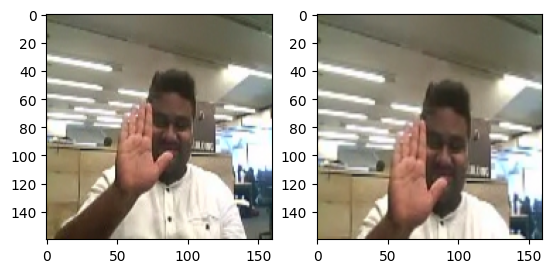

In [10]:
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.transform import resize

# Create an instance of ModelConv3D1 for testing data generation:
test_generator = ModelConv3D1()

# Initialize paths for data loading:
test_generator.initialize_path(project_folder)

# Initialize image properties:
test_generator.initialize_image_properties(image_height=160, image_width=160)

# Initialize hyperparameters:
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3, num_epochs=1)

# Generate data using the generator:
g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)

# Load a batch of data and labels:
batch_data, batch_labels = next(g)

# Display a sample from the batch:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0, 15, :, :, :])  # Displaying a frame from the first sample in the batch
axes[1].imshow(batch_data[3, 15, :, :, :])  # Displaying a frame from the fourth sample in the batch


### Testing different configurations of image resolution, frame count, and batch size.

In [11]:
#conv_3d1.train_model(conv_3d1_model)

- We had reached the memory capacity limit while processing images at a resolution of 160x160 with 30 frames and a batch size of 40, resulting in the error.

In [12]:
import numpy as np

# Calculate the memory utilization:
memory_utilization = getsizeof(np.zeros((40,16,30,160,160))) / (1024*1024*1024)

# Print the memory utilization:
print("Memory util is {} Gigs".format(memory_utilization))


Memory util is 3.662109538912773 Gigs


### Trade-off Between The Parameters:

- Here are the experiments conducted to observe the impact of image resolution, sequence size, and batch size on training time.

In [13]:
# Create an instance of ModelConv3D1:
conv_3d1 = ModelConv3D1()

# Initialize paths for data loading:
conv_3d1.initialize_path(project_folder)

# Initialize image properties:
conv_3d1.initialize_image_properties(image_height=100, image_width=100)

# Initialize hyperparameters:
conv_3d1.initialize_hyperparams(frames_to_sample=15, batch_size=30, num_epochs=2)

# Define the model architecture:
conv_3d1_model = conv_3d1.define_model()

# Print the total number of parameters in the model:
print("Total Params:", conv_3d1_model.count_params())

# Train the model:
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3389 - loss: 1.7377
Epoch 1: val_loss improved from inf to 2.12369, saving model to model_init_2024-04-2419_58_12.990693/model-00001-1.42743-0.43439-2.12369-0.21000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - categorical_accuracy: 0.3429 - loss: 1.7248 - val_categorical_accuracy: 0.2100 - val_loss: 2.1237 - learning_rate: 0.0010
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6586 - loss: 0.9261
Epoch 2: val_loss did not improve from 2.12369
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - categorical_accuracy: 0.6587 - loss: 0.9256 - val_categorical_accuracy: 0.2100 - val_loss: 3.0940 - learning_rate: 0.0010


In [14]:
# Create an instance of ModelConv3D1:
conv_3d1 = ModelConv3D1()

# Initialize paths for data loading:
conv_3d1.initialize_path(project_folder)

# Initialize image properties:
conv_3d1.initialize_image_properties(image_height=100, image_width=100)

# Initialize hyperparameters:
conv_3d1.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=2)

# Define the model architecture:
conv_3d1_model = conv_3d1.define_model()

# Print the total number of parameters in the model:
print("Total Params:", conv_3d1_model.count_params())

# Train the model:
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3377 - loss: 1.7771
Epoch 1: val_loss improved from inf to 2.41925, saving model to model_init_2024-04-2420_04_25.655128/model-00001-1.47217-0.41931-2.41925-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - categorical_accuracy: 0.3400 - loss: 1.7684 - val_categorical_accuracy: 0.1600 - val_loss: 2.4192 - learning_rate: 0.0010
Epoch 2/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5874 - loss: 0.9919
Epoch 2: val_loss did not improve from 2.41925
34/34 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - categorical_accuracy: 0.5876 - loss: 0.9943 - val_categorical_accuracy: 0.1600 - val_loss: 4.2645 - learning_rate: 0.0010


In [15]:
# Instantiate the ModelConv3D1 class:
conv_3d1 = ModelConv3D1()

# Initialize the path for the project folder:
conv_3d1.initialize_path(project_folder)

# Initialize image properties:
conv_3d1.initialize_image_properties(image_height=160, image_width=160)

# Initialize hyperparameters:
conv_3d1.initialize_hyperparams(frames_to_sample=30, batch_size=15, num_epochs=2)

# Define the convolutional 3D model:
conv_3d1_model = conv_3d1.define_model()

# Print total parameters in the model:
print("Total Params:", conv_3d1_model.count_params())

# Train the model:
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.3980 - loss: 1.5718
Epoch 1: val_loss improved from inf to 10.92617, saving model to model_init_2024-04-2420_16_02.278663/model-00001-1.36962-0.46456-10.92617-0.16000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 326s 7s/step - categorical_accuracy: 0.3995 - loss: 1.5674 - val_categorical_accuracy: 0.1600 - val_loss: 10.9262 - learning_rate: 0.0010
Epoch 2/2
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6009 - loss: 1.0049
Epoch 2: val_loss did not improve from 10.92617
45/45 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - categorical_accuracy: 0.6016 - loss: 1.0043 - val_categorical_accuracy: 0.1600 - val_loss: 11.6735 - learning_rate: 0.0010


In [16]:
# Instantiate the ModelConv3D1 class:
conv_3d1 = ModelConv3D1()

# Initialize the path for the project folder:
conv_3d1.initialize_path(project_folder)

# Initialize image properties:
conv_3d1.initialize_image_properties(image_height=160, image_width=160)

# Initialize hyperparameters:
conv_3d1.initialize_hyperparams(frames_to_sample=16, batch_size=30, num_epochs=2)

# Define the convolutional 3D model:
conv_3d1_model = conv_3d1.define_model()

# Print total parameters in the model:
print("Total Params:", conv_3d1_model.count_params())

# Train the model:
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.4047 - loss: 1.5851
Epoch 1: val_loss improved from inf to 4.21964, saving model to model_init_2024-04-2420_29_16.032478/model-00001-1.36212-0.46908-4.21964-0.21000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 188s 8s/step - categorical_accuracy: 0.4074 - loss: 1.5758 - val_categorical_accuracy: 0.2100 - val_loss: 4.2196 - learning_rate: 0.0010
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.6611 - loss: 0.9249
Epoch 2: val_loss did not improve from 4.21964
23/23 ━━━━━━━━━━━━━━━━━━━━ 172s 8s/step - categorical_accuracy: 0.6608 - loss: 0.9253 - val_categorical_accuracy: 0.2100 - val_loss: 7.1095 - learning_rate: 0.0010


- The experiments illustrate that both image resolution and the number of frames in a sequence have a greater effect on training time compared to batch size.
- We will consider a batch size within the range of 15 to 40.
- We will adjust the resolution to either 160x160 or 120x120 based on the model's performance.


### Model 1:
### Base Model, Batch Size = 40 and No. of Epochs = 15:

In [17]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        model = Sequential()

        # 1st Convolutional Layer:
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 2nd Convolutional Layer:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 3rd Convolutional Layer:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 4th Convolutional Layer:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten the layers:
        model.add(Flatten())

        # 1st Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # 2nd Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model:
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [18]:
# Instantiate the ModelConv3D1 class:
conv_3d1 = ModelConv3D1()

# Initialize the path for the project folder:
conv_3d1.initialize_path(project_folder)

# Initialize image properties:
conv_3d1.initialize_image_properties(image_height=160, image_width=160)

# Initialize hyperparameters:
conv_3d1.initialize_hyperparams(frames_to_sample=20, batch_size=40, num_epochs=15)

# Define the convolutional 3D model:
conv_3d1_model = conv_3d1.define_model()

# Display model summary:
conv_3d1_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)              │ (None, 20, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 20, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 20, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_20 (MaxPooling3D) │ (None, 10, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_21 (Conv3D)              │ (None, 10, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 10, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 10, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_21 (MaxPooling3D) │ (None, 5, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_22 (Conv3D)              │ (None, 5, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 5, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 5, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 2, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_23 (Conv3D)              │ (None, 2, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 2, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 2, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,117,061 (4.26 MB)

 Trainable params: 1,116,325 (4.26 MB)

 Non-trainable params: 736 (2.88 KB)

In [19]:
# Print total parameters in the model:
print("Total Params:", conv_3d1_model.count_params())

# Train the model and store the training history:
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.3232 - loss: 1.8291 
Epoch 1: val_loss improved from inf to 1.63510, saving model to model_init_2024-04-2322_49_22.869902/model-00001-1.46626-0.42534-1.63510-0.20000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 221s 12s/step - categorical_accuracy: 0.3289 - loss: 1.8089 - val_categorical_accuracy: 0.2000 - val_loss: 1.6351 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.6459 - loss: 0.8827 
Epoch 2: val_loss did not improve from 1.63510
17/17 ━━━━━━━━━━━━━━━━━━━━ 188s 11s/step - categorical_accuracy: 0.6474 - loss: 0.8794 - val_categorical_accuracy: 0.2300 - val_loss: 2.6668 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.8170 - loss: 0.5272 
Epoch 3: val_loss did not improve from 1.63510
17/17 ━━━━━━━━━━━━━━━━━━━━ 196s 12s/step - categorical_accuracy: 0.8167 - loss: 0.5269 - val_categorical_accurac

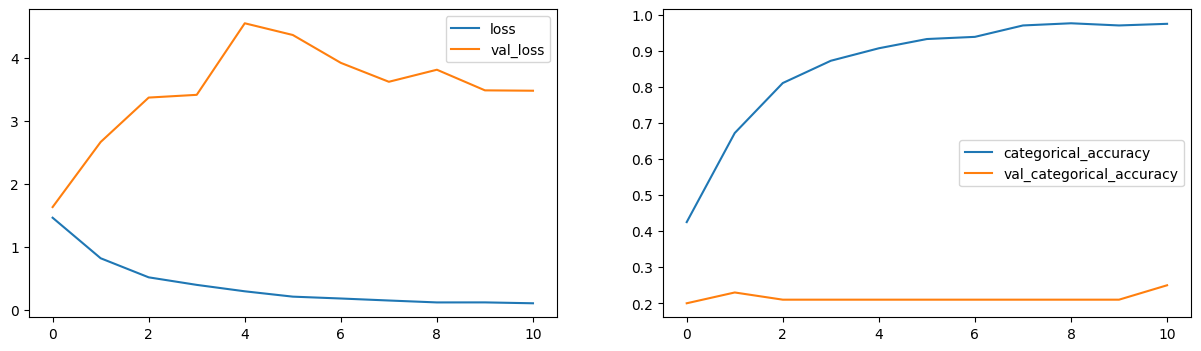

In [20]:
# Plot the training history:
plot(history_model1)

### Observations: The model is learning too much from the training data and not generalizing well to new data.

### Model 2:  
### Adding dropout layers, Batch Size = 20 and No. of Epochs = 25:

In [21]:
# Instantiate the ModelConv3D1 class:
conv_3d2 = ModelConv3D1()

# Initialize the path for the project folder:
conv_3d2.initialize_path(project_folder)

# Initialize image properties:
conv_3d2.initialize_image_properties(image_height=160, image_width=160)

# Initialize hyperparameters:
conv_3d2.initialize_hyperparams(frames_to_sample=20, batch_size=20, num_epochs=25)

# Define the convolutional 3D model with custom parameters:
conv_3d2_model = conv_3d2.define_model(dense_neurons=256, dropout=0.5)

# Display model summary:
conv_3d2_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)              │ (None, 20, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 20, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 20, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_24 (MaxPooling3D) │ (None, 10, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_25 (Conv3D)              │ (None, 10, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 10, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 10, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_25 (MaxPooling3D) │ (None, 5, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_26 (Conv3D)              │ (None, 5, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 5, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 5, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_26 (MaxPooling3D) │ (None, 2, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_27 (Conv3D)              │ (None, 2, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 2, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 2, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,638,981 (13.88 MB)

 Trainable params: 3,637,477 (13.88 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [22]:
# Print total parameters in the model:
print("Total Params:", conv_3d2_model.count_params())

# Train the model with data augmentation and store the training history:
history_model2 = conv_3d2.train_model(conv_3d2_model, augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.3586 - loss: 2.0295 
Epoch 1: val_loss improved from inf to 2.07194, saving model to model_init_2024-04-2323_26_04.275111/model-00001-1.89785-0.40271-2.07194-0.27000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 370s 11s/step - categorical_accuracy: 0.3599 - loss: 2.0257 - val_categorical_accuracy: 0.2700 - val_loss: 2.0719 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.4936 - loss: 1.4478 
Epoch 2: val_loss did not improve from 2.07194
34/34 ━━━━━━━━━━━━━━━━━━━━ 346s 10s/step - categorical_accuracy: 0.4943 - loss: 1.4471 - val_categorical_accuracy: 0.2100 - val_loss: 3.5018 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.6187 - loss: 1.1295 
Epoch 3: val_loss did not improve from 2.07194
34/34 ━━━━━━━━━━━━━━━━━━━━ 347s 10s/step - categorical_accuracy: 0.6186 - loss: 1.1306 - val_categorical_accurac

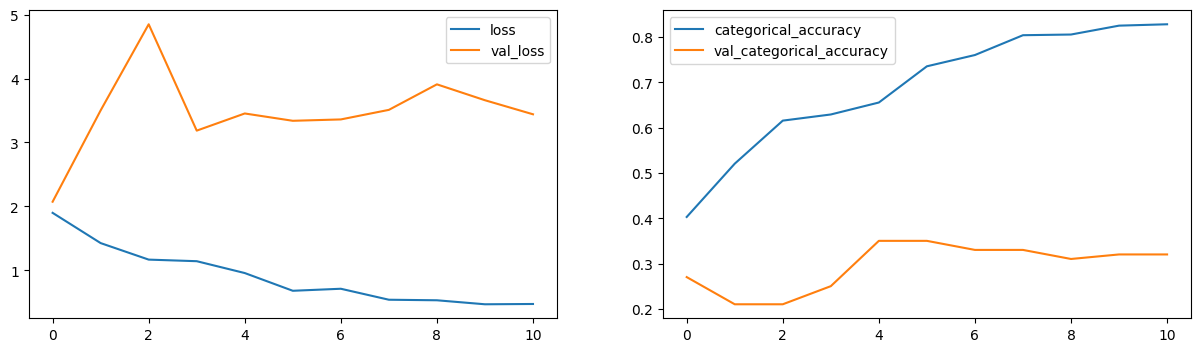

In [23]:
# Plot the training history:
plot(history_model2)

##### The epoch is automatically stopped early by early stopping since the validation loss did not show any improvement. 
- Early stopping did a great job by stopping the last epoch on the 11th out of 25 epochs!
- The best weights were automatically saved. With a validation accuracy and training accuracy, we'll now experiment with reducing the filter size and image resolution to potentially improve results. Additionally, to address the minor oscillations in loss, let's decrease the learning rate to 0.0002 and observe the effects.

### Model 3:
### Reducing filter size to (2,2,2) and image res to 120 x  120, Batch Size = 30 and No. of Epochs = 25

In [24]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):

        model = Sequential()

        # 1st Convolutional Layer:
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 2nd Convolutional Layer:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 3rd Convolutional Layer:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 4th Convolutional Layer:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten the layers:
        model.add(Flatten())

        # 1st Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # 2nd Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer:
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile the model with a learning rate:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [25]:

# Instantiate the ModelConv3D3 class:
conv_3d3 = ModelConv3D3()

# Initialize the path for the project folder:
conv_3d3.initialize_path(project_folder)

# Initialize image properties:
conv_3d3.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
conv_3d3.initialize_hyperparams(frames_to_sample=16, batch_size=30, num_epochs=25)

# Define the convolutional 3D model with custom parameters:
conv_3d3_model = conv_3d3.define_model(filtersize=(2, 2, 2), dense_neurons=256, dropout=0.5)

# Display model summary:
conv_3d3_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)              │ (None, 16, 120, 120,   │           400 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_28 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 8, 60, 60, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_29 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_30 (Conv3D)              │ (None, 4, 30, 30, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_30 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 2, 15, 15, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_31 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,762,613 (6.72 MB)

 Trainable params: 1,761,109 (6.72 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [26]:
# Print total parameters in the model:
print("Total Params:", conv_3d3_model.count_params())

# Train the model with data augmentation and store the training history:
history_model3 = conv_3d3.train_model(conv_3d3_model, augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2960 - loss: 2.2941
Epoch 1: val_loss improved from inf to 1.91842, saving model to model_init_2024-04-2400_36_41.961447/model-00001-2.04103-0.34163-1.91842-0.21000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 229s 10s/step - categorical_accuracy: 0.2979 - loss: 2.2836 - val_categorical_accuracy: 0.2100 - val_loss: 1.9184 - learning_rate: 2.0000e-04
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.5053 - loss: 1.4446
Epoch 2: val_loss did not improve from 1.91842
23/23 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - categorical_accuracy: 0.5058 - loss: 1.4436 - val_categorical_accuracy: 0.2100 - val_loss: 2.8313 - learning_rate: 2.0000e-04
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.6066 - loss: 1.1174
Epoch 3: val_loss did not improve from 1.91842
23/23 ━━━━━━━━━━━━━━━━━━━━ 189s 8s/step - categorical_accuracy: 0.6061 - loss: 1.1163 - val_categorical_accurac

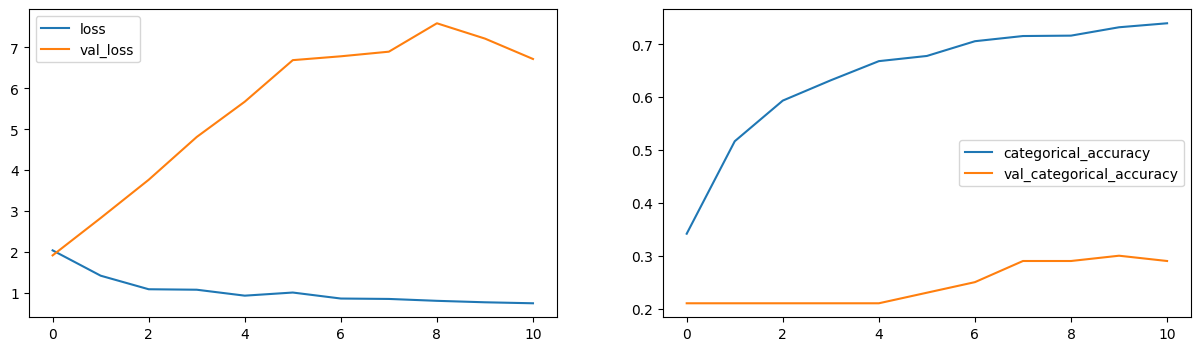

In [27]:
# Plot the training history:
plot(history_model3)

### Observations: The model achieved a slight improvement. We've successfully reduced the parameter size by half compared to the earlier model. Now, let's experiment with adding more layers to further enhance the model's performance.

### Model 4: 
### Adding more layers, Batch Size = 20 and No. of Epochs = 25:

In [28]:
class ModelConv3D4(ModelBuilder):

    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        """
        Define the architecture of the 3D convolutional neural network model.

        Args:
            filtersize: Size of the filters for convolutional layers.
            dense_neurons: Number of neurons in the dense layers.
            dropout: Dropout rate to prevent overfitting."""

        # Initialize a sequential model:
        model = Sequential()

        # 1st Convolutional Layer:
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # 2nd Convolutional Layer:
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Max Pooling Layer:
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 3rd Convolutional Layer:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # 4th Convolutional Layer:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Max Pooling Layer:
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 5th Convolutional Layer:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # 6th Convolutional Layer:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Max Pooling Layer:
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 7th Convolutional Layer:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # 8th Convolutional Layer:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Max Pooling Layer:
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten Layer:
        model.add(Flatten())

        # 1st Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # 2nd Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model:
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [29]:
# Initialize ModelConv3D4 object:
conv_3d4 = ModelConv3D4()

# Initialize paths:
conv_3d4.initialize_path(project_folder)

# Initialize image properties:
conv_3d4.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
conv_3d4.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=25)

# Define the model:
conv_3d4_model = conv_3d4.define_model(filtersize=(3, 3, 3), dense_neurons=256, dropout=0.5)

# Display model summary:
conv_3d4_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_32 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_33 (Conv3D)              │ (None, 16, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_32 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_34 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_35 (Conv3D)              │ (None, 8, 60, 60, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_33 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_36 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_37 (Conv3D)              │ (None, 4, 30, 30, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [30]:
# Print total parameters of the model:
print("Total Params:", conv_3d4_model.count_params())

# Train the model and store the history:
history_model4 = conv_3d4.train_model(conv_3d4_model, augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3232 - loss: 2.0500
Epoch 1: val_loss improved from inf to 2.47015, saving model to model_init_2024-04-2401_12_59.697475/model-00001-1.88661-0.38537-2.47015-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 306s 9s/step - categorical_accuracy: 0.3249 - loss: 2.0453 - val_categorical_accuracy: 0.2100 - val_loss: 2.4702 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4528 - loss: 1.6136
Epoch 2: val_loss did not improve from 2.47015
34/34 ━━━━━━━━━━━━━━━━━━━━ 293s 9s/step - categorical_accuracy: 0.4531 - loss: 1.6127 - val_categorical_accuracy: 0.2100 - val_loss: 5.6518 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.5043 - loss: 1.3778
Epoch 3: val_loss improved from 2.47015 to 2.17326, saving model to model_init_2024-04-2401_12_59.697475/model-00003-1.35121-0.51508-2.17326-0.16000.keras
34/34 ━━━━━━

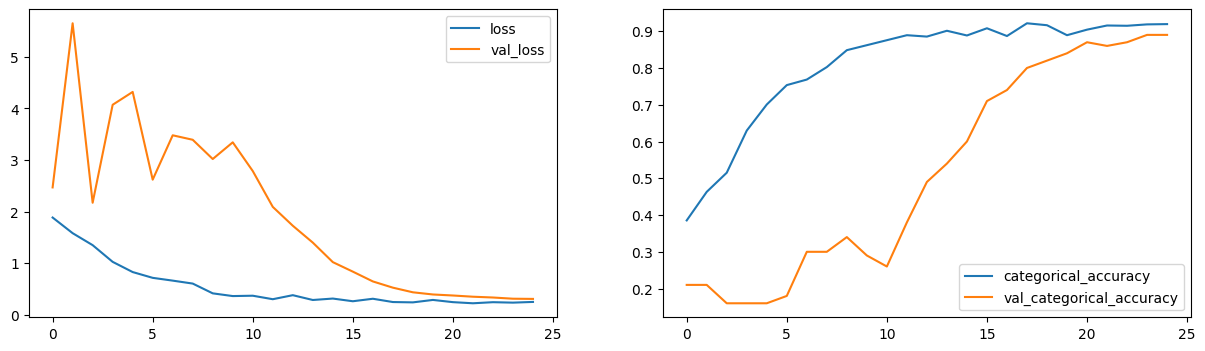

In [31]:
# Plot the training history:
plot(history_model4)

### Observations: With the addition of more layers, we haven't observed significant performance improvement. To enhance the model's performance, let's introduce dropout layers at the convolutional layers and observe the effects.

### Model 5:
### Adding dropout at convolution layers:

In [32]:
class ModelConv3D5(ModelBuilder):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        
        # Initialize the Sequential model:
        model = Sequential()

        # First Conv3D layer:
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Second Conv3D layer:
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # MaxPooling layer and Dropout:
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # Third Conv3D layer:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Fourth Conv3D layer:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # MaxPooling layer and Dropout:
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # Fifth Conv3D layer:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Sixth Conv3D layer:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # MaxPooling layer and Dropout:
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # Seventh Conv3D layer:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Eighth Conv3D layer:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # MaxPooling layer and Dropout:
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # Flatten layer:
        model.add(Flatten())

        # First Dense layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Second Dense layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model:
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [33]:
# Create an instance of ModelConv3D5:
conv_3d5 = ModelConv3D5()

# Initialize paths:
conv_3d5.initialize_path(project_folder)

# Initialize image properties:
conv_3d5.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
conv_3d5.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=15)

# Define the model:
conv_3d5_model = conv_3d5.define_model(filtersize=(3, 3, 3), dense_neurons=256, dropout=0.25)

# Print model summary:
conv_3d5_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_40 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_41 (Conv3D)              │ (None, 16, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_36 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_42 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_43 (Conv3D)              │ (None, 8, 60, 60, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_37 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_44 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_45 (Conv3D)              │ (None, 4, 30, 30, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [34]:
# Print total parameters of the model:
print("Total Params:", conv_3d5_model.count_params())

# Train the model and store the training history:
history_model5 = conv_3d5.train_model(conv_3d5_model, augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3732 - loss: 1.8598
Epoch 1: val_loss improved from inf to 1.84343, saving model to model_init_2024-04-2403_13_27.084265/model-00001-1.66555-0.41629-1.84343-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 298s 9s/step - categorical_accuracy: 0.3744 - loss: 1.8542 - val_categorical_accuracy: 0.2100 - val_loss: 1.8434 - learning_rate: 0.0010
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4772 - loss: 1.3903
Epoch 2: val_loss improved from 1.84343 to 1.73635, saving model to model_init_2024-04-2403_13_27.084265/model-00002-1.36973-0.49849-1.73635-0.32000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 286s 8s/step - categorical_accuracy: 0.4778 - loss: 1.3897 - val_categorical_accuracy: 0.3200 - val_loss: 1.7363 - learning_rate: 0.0010
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.6257 - loss: 1.0593
Epoch 3: val_loss did not improve from 1.73635
34/34 ━━━━━━

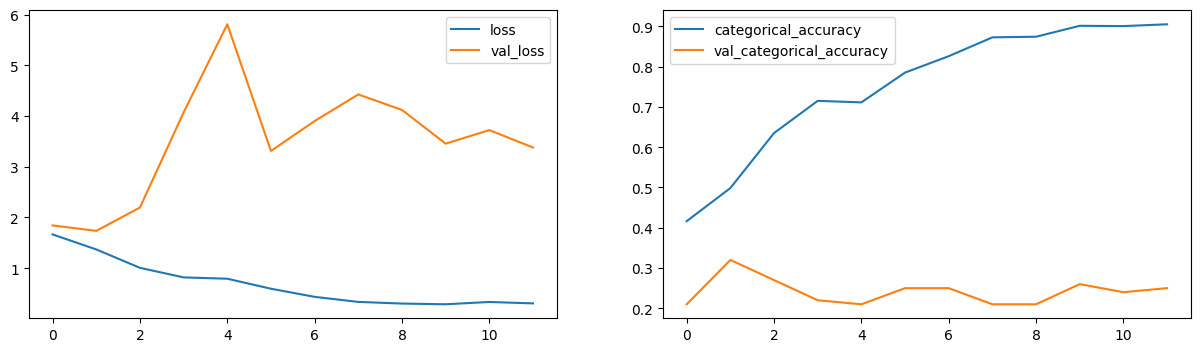

In [35]:
# Plot the training history:
plot(history_model5)

### Observations: It seems that adding dropouts at the convolutional layers has led to overfitting again, as indicated by the reduction in validation accuracy. The model is struggling to generalize well to unseen data.

- The experimental models mentioned above all have a large number of parameters. Let's aim to decrease the model size and evaluate its performance accordingly.

### Model 6: 
### Reducing the number of parameters:

In [36]:
class ModelConv3D6(ModelBuilder):
    def define_model(self, dense_neurons=64, dropout=0.25):
        
        # Initialize the Sequential model:
        model = Sequential()

        # First Conv3D layer:
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Second Conv3D layer:
        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Third Conv3D layer:
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Fourth Conv3D layer:
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Flatten layer:
        model.add(Flatten())

        # First Dense layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Second Dense layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model with a learning rate:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [37]:
# Create an instance of ModelConv3D6:
conv_3d6 = ModelConv3D6()

# Initialize paths:
conv_3d6.initialize_path(project_folder)

# Initialize image properties:
conv_3d6.initialize_image_properties(image_height=100, image_width=100)

# Initialize hyperparameters:
conv_3d6.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=20)

# Define the model:
conv_3d6_model = conv_3d6.define_model(dense_neurons=128, dropout=0.25)

# Print model summary:
conv_3d6_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_48 (Conv3D)              │ (None, 16, 100, 100,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 16, 100, 100,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 16, 100, 100,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_40 (MaxPooling3D) │ (None, 8, 50, 50, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_49 (Conv3D)              │ (None, 8, 50, 50, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 8, 50, 50, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 8, 50, 50, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_41 (MaxPooling3D) │ (None, 4, 25, 25, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_50 (Conv3D)              │ (None, 4, 25, 25, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 4, 25, 25, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 4, 25, 25, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_42 (MaxPooling3D) │ (None, 2, 12, 12, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_51 (Conv3D)              │ (None, 2, 12, 12, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 2, 12, 12, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 2, 12, 12, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_43 (MaxPooling3D) │ (None, 1, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 696,645 (2.66 MB)

 Trainable params: 695,653 (2.65 MB)

 Non-trainable params: 992 (3.88 KB)

In [38]:
# Print total parameters of the model:
print("Total Params:", conv_3d6_model.count_params())

# Train the model and store the training history:
history_model6 = conv_3d6.train_model(conv_3d6_model, augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2933 - loss: 1.9879
Epoch 1: val_loss improved from inf to 1.84093, saving model to model_init_2024-04-2404_11_55.138738/model-00001-1.74695-0.36878-1.84093-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - categorical_accuracy: 0.2954 - loss: 1.9810 - val_categorical_accuracy: 0.1600 - val_loss: 1.8409 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.5421 - loss: 1.2132
Epoch 2: val_loss did not improve from 1.84093
34/34 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - categorical_accuracy: 0.5427 - loss: 1.2122 - val_categorical_accuracy: 0.1600 - val_loss: 2.5105 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.6328 - loss: 0.9397
Epoch 3: val_loss did not improve from 1.84093
34/34 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - categorical_accuracy: 0.6326 - loss: 0.9405 - val_categorical_accuracy:

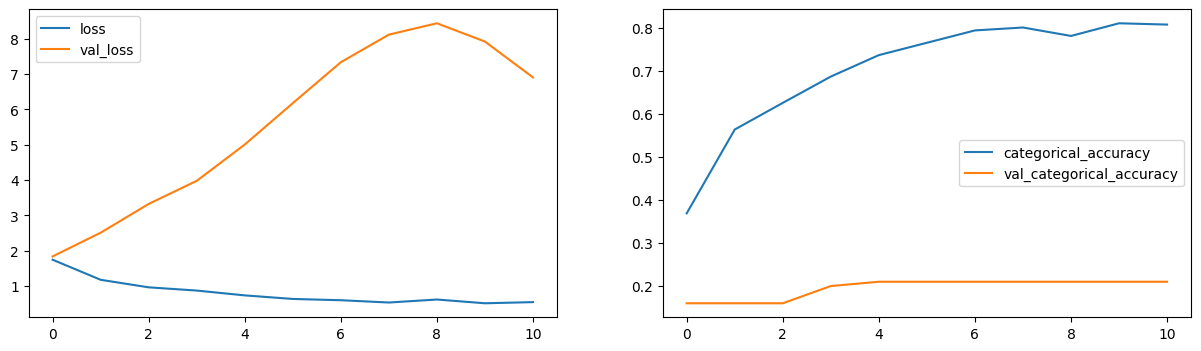

In [39]:
# Plot the training history:
plot(history_model6)

### Observations: Validation accuracy low.

### Model 7:
### Reducing the number of parameters again:

In [40]:
class ModelConv3D7(ModelBuilder):
    def define_model(self, dense_neurons=64, dropout=0.25):
        """
        Defines the 3D convolutional neural network model.

        Args:
        - dense_neurons: Number of neurons in the dense layers.
        - dropout: Dropout rate for regularization."""
        
        # Initialize the Sequential model:
        model = Sequential()

        # First Conv3D layer:
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Second Conv3D layer:
        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Third Conv3D layer:
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Fourth Conv3D layer:
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Flatten layer:
        model.add(Flatten())

        # First Dense layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Second Dense layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model with a learning rate:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [41]:
# Create an instance of ModelConv3D7:
conv_3d7 = ModelConv3D7()

# Initialize paths:
conv_3d7.initialize_path(project_folder)

# Initialize image properties:
conv_3d7.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
conv_3d7.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=25)

# Define the model:
conv_3d7_model = conv_3d7.define_model(dense_neurons=64, dropout=0.25)

# Print model summary:
conv_3d7_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_52 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_44 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_53 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_45 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_54 (Conv3D)              │ (None, 4, 30, 30, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_46 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_55 (Conv3D)              │ (None, 2, 15, 15, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_47 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 504,709 (1.93 MB)

 Trainable params: 503,973 (1.92 MB)

 Non-trainable params: 736 (2.88 KB)

In [42]:
# Print total parameters of the model:
print("Total Params:", conv_3d7_model.count_params())

# Train the model and store the training history:
history_model7 = conv_3d7.train_model(conv_3d7_model, augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2991 - loss: 1.9257
Epoch 1: val_loss improved from inf to 1.91713, saving model to model_init_2024-04-2404_40_43.693699/model-00001-1.69035-0.38009-1.91713-0.15000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 206s 6s/step - categorical_accuracy: 0.3014 - loss: 1.9190 - val_categorical_accuracy: 0.1500 - val_loss: 1.9171 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5147 - loss: 1.2122
Epoch 2: val_loss did not improve from 1.91713
34/34 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - categorical_accuracy: 0.5151 - loss: 1.2116 - val_categorical_accuracy: 0.1600 - val_loss: 2.9279 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6298 - loss: 0.9302
Epoch 3: val_loss did not improve from 1.91713
34/34 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - categorical_accuracy: 0.6298 - loss: 0.9302 - val_categorical_accuracy:

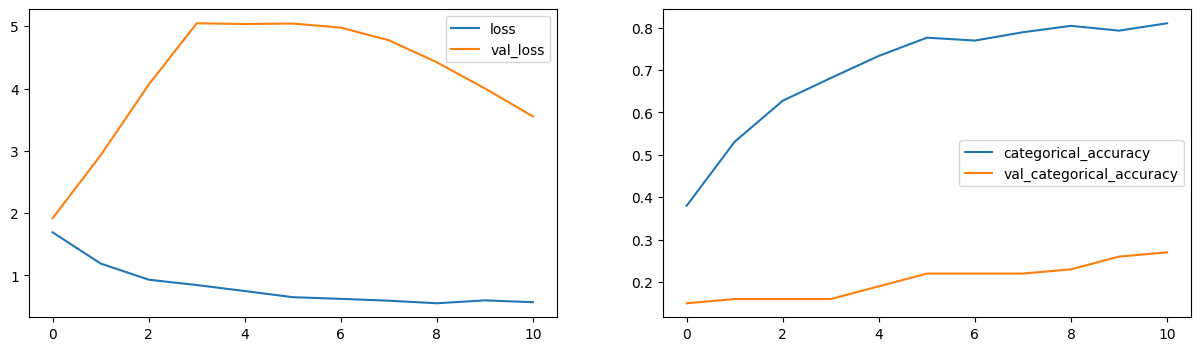

In [43]:
# Plot the training history:
plot(history_model7)

### ObservationS: It seems there hasn't been a noticeable improvement in the validation accuracy.

### Model 8:
### CNN- LSTM Model:

In [18]:
class RNNCNN1(ModelBuilder):
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        """
        Defines the RNN-CNN hybrid model.

        Args:
        - lstm_cells: Number of LSTM cells.
        - dense_neurons: Number of neurons in the dense layers.
        - dropout: Dropout rate for regularization."""

        # Initialize the Sequential model:
        model = Sequential()

        # TimeDistributed Conv2D layers:
        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        # LSTM layer:
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        # Dense layers:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model:
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [19]:
# Create an instance of RNNCNN1:
rnn_cnn1 = RNNCNN1()

# Initialize paths:
rnn_cnn1.initialize_path(project_folder)

# Initialize image properties:
rnn_cnn1.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
rnn_cnn1.initialize_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=20)

# Define the model:
rnn_cnn1_model = rnn_cnn1.define_model(lstm_cells=128, dense_neurons=128, dropout=0.25)

# Print model summary:
rnn_cnn1_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 18, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 18, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 18, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 18, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 18, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 18, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 18, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 18, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 18, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 18, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 18, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 18, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 18, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 18, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 18, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 18, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,245,69

 Total params: 1,657,445 (6.32 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

In [28]:
# Print total parameters of the model:
print("Total Params:", rnn_cnn1_model.count_params())

# Train the model and store the training history:
history_model8 = rnn_cnn1.train_model(rnn_cnn1_model, augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 48s/step - categorical_accuracy: 0.3745 - loss: 1.4830 
Epoch 1: val_loss improved from inf to 1.10185, saving model to model_init_2024-04-2606_44_18.112538/model-00001-1.36408-0.43288-1.10185-0.56000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1712s 49s/step - categorical_accuracy: 0.3762 - loss: 1.4796 - val_categorical_accuracy: 0.5600 - val_loss: 1.1018 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - categorical_accuracy: 0.5498 - loss: 1.1093 
Epoch 2: val_loss improved from 1.10185 to 0.85793, saving model to model_init_2024-04-2606_44_18.112538/model-00002-1.05059-0.57843-0.85793-0.69000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1693s 50s/step - categorical_accuracy: 0.5506 - loss: 1.1076 - val_categorical_accuracy: 0.6900 - val_loss: 0.8579 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - categorical_accuracy: 0.6745 - loss: 0.8447 
Epoch 3: val_loss improved from 0.85793 to 0.7070

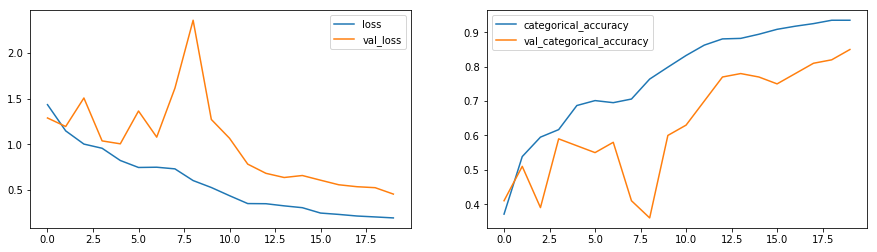

In [ ]:
# Plot the training history:
plot(history_model8)

### Observations: We achieved the highest validation accuracy of 89% with the CNN-LSTM model.

- As we notice more cases of overfitting, let's augment the data with slight rotation as well and re-run the same set of models.

### Let's employ some data augmentation and check the model's performance:

In [11]:
class ModelBuilderMoreAugmentation(metaclass=abc.ABCMeta):
    
    def initialize_path(self, project_folder):
        # Initializing paths for training and validation data:
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self, image_height=100, image_width=100):
        # Initializing image properties:
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        # Initializing hyperparameters:
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    def generator(self, source_path, folder_list, augment=False):
        # Data generator for training and validation:
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t) % batch_size
        
            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        # Processing one batch of data:
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
    
        if augment: 
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]) 
            for idx, item in enumerate(img_idx): 
                image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))

                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
            
                if augment:
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    cropped = shifted[x0:x1, y0:y1, :]
                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))
                    M = cv2.getRotationMatrix2D((self.image_width // 2, self.image_height // 2), np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
            
                    batch_data_aug[folder, idx, :, :, 0] = (rotated[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (rotated[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (rotated[:, :, 2]) / 255
                
            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            
        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])
        
        return batch_data, batch_labels
    
    def train_model(self, model, augment_data=False):
        # Training the model:
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
         #Originally, the code intended to save the model in the '.h5' format. However, due to encountering an error, it has been adjusted to save the model in the '.keras' format instead.

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if self.num_train_sequences % self.batch_size == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if self.num_val_sequences % self.batch_size == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1
    
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                                      callbacks=callbacks_list, validation_data=val_generator, 
                                      validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history
        
    @abc.abstractmethod
    def define_model(self):
        pass


-  Originally, the code intended to save the model in the '.h5' format. However, due to encountering an error, it has been adjusted to save the model in the '.keras' format instead.

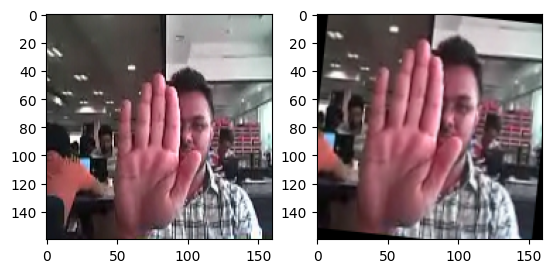

In [12]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

# Creating an instance of Test generator:
test_generator = Test()

# Initializing paths, image properties, and hyperparameters:
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160, image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3, num_epochs=1)

# Generating data for testing:
g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)
batch_data, batch_labels = next(g)

# Displaying sample images from the generated batch:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0, 29, :, :, :])   
axes[1].imshow(batch_data[3, 29, :, :, :])   

### Model 9 with Augmentation:
### (3,3,3) Filter & 160x160 Image resolution, similar to Model 2:

In [13]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    # Define the architecture of the 3D convolutional neural network model:

    def define_model(self, filtersize=(3,3,3), dense_neurons=64, dropout=0.25):
        # Initialize the sequential model:
        model = Sequential()

        # Add the first convolutional layer with 16 filters:
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Add the second convolutional layer with 32 filters:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Add the third convolutional layer with 64 filters:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Add the fourth convolutional layer with 128 filters:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten the output from the convolutional layers:
        model.add(Flatten())

        # Add a fully connected layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Add another fully connected layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Add the output layer with softmax activation for multiclass classification:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model with Adam optimizer and categorical crossentropy loss:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [14]:
# Create an instance of ModelConv3D9:
conv_3d9 = ModelConv3D9()

# Initialize the file paths for the project:
conv_3d9.initialize_path(project_folder)

# Initialize the image properties with the specified height and width:
conv_3d9.initialize_image_properties(image_height=160, image_width=160)

# Initialize the hyperparameters:
conv_3d9.initialize_hyperparams(frames_to_sample=20, batch_size=20, num_epochs=20)

# Define the 3D convolutional neural network model:
conv_3d9_model = conv_3d9.define_model(dense_neurons=256, dropout=0.5)

# Display the summary of the model architecture:
conv_3d9_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 20, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 20, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 10, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 10, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 5, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 5, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 5, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 2, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 2, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 2, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,638,981 (13.88 MB)

 Trainable params: 3,637,477 (13.88 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [20]:
# Print the total number of parameters in the model:
print("Total Params:", conv_3d9_model.count_params())

# Train the defined model using the specified augmentation settings and store the training history:
history_model9 = conv_3d9.train_model(conv_3d9_model, augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - categorical_accuracy: 0.3034 - loss: 2.2302 
Epoch 1: saving model to model_init_2024-04-2421_58_31.596210/model-00001-1.96462-0.36124-2.09309-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 429s 13s/step - categorical_accuracy: 0.3051 - loss: 2.2226 - val_categorical_accuracy: 0.2100 - val_loss: 2.0931 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.4906 - loss: 1.4711 
Epoch 2: saving model to model_init_2024-04-2421_58_31.596210/model-00002-1.41146-0.50754-3.79065-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 382s 11s/step - categorical_accuracy: 0.4911 - loss: 1.4694 - val_categorical_accuracy: 0.2100 - val_loss: 3.7907 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.5942 - loss: 1.2049 
Epoch 3: saving model to model_init_2024-04-2421_58_31.596210/model-00003-1.15303-0.59427-5.77589-0.21000.keras
34/34 ━━━━━━━

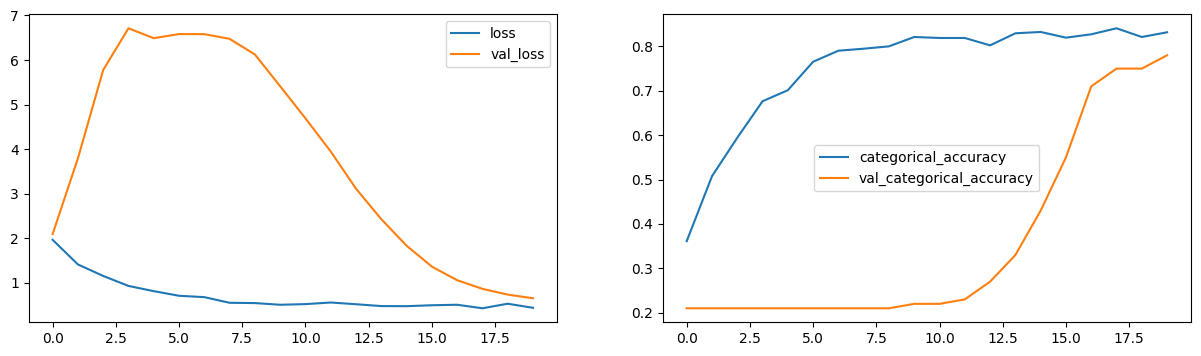

In [21]:
# Plot the training history of model9:
plot(history_model9)

### Model 10 with Augmentation:
### (2,2,2) Filter  & 120x120 Image resolution, similar to Model 3:

In [22]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
       
        model = Sequential()

        # 1st Convolutional Layer:
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 2nd Convolutional Layer:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 3rd Convolutional Layer:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 4th Convolutional Layer:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer:
        model.add(Flatten())

        # 1st Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # 2nd Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile model:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [23]:
# Instantiate ModelConv3D10:
conv_3d10 = ModelConv3D10()

# Initialize paths and image properties:
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
conv_3d10.initialize_hyperparams(frames_to_sample=16, batch_size=30, num_epochs=25)

# Define and compile the model:
conv_3d10_model = conv_3d10.define_model(filtersize=(2, 2, 2), dense_neurons=256, dropout=0.5)

# Display model summary:
conv_3d10_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 16, 120, 120,   │           400 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 8, 60, 60, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 4, 30, 30, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 2, 15, 15, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,762,613 (6.72 MB)

 Trainable params: 1,761,109 (6.72 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [24]:
# Print total parameters of the model:
print("Total Params:", conv_3d10_model.count_params())

# Train the model and store the training history"
history_model10 = conv_3d10.train_model(conv_3d10_model, augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2775 - loss: 2.3503
Epoch 1: saving model to model_init_2024-04-2500_10_31.587129/model-00001-2.03378-0.33710-1.98209-0.23000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 212s 9s/step - categorical_accuracy: 0.2800 - loss: 2.3371 - val_categorical_accuracy: 0.2300 - val_loss: 1.9821 - learning_rate: 2.0000e-04
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4953 - loss: 1.4757
Epoch 2: saving model to model_init_2024-04-2500_10_31.587129/model-00002-1.46352-0.50377-3.10966-0.16000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - categorical_accuracy: 0.4956 - loss: 1.4752 - val_categorical_accuracy: 0.1600 - val_loss: 3.1097 - learning_rate: 2.0000e-04
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.6012 - loss: 1.1571
Epoch 3: saving model to model_init_2024-04-2500_10_31.587129/model-00003-1.14136-0.61237-3.89506-0.16000.keras
23/23 ━━━━━━━━━━━━━━━

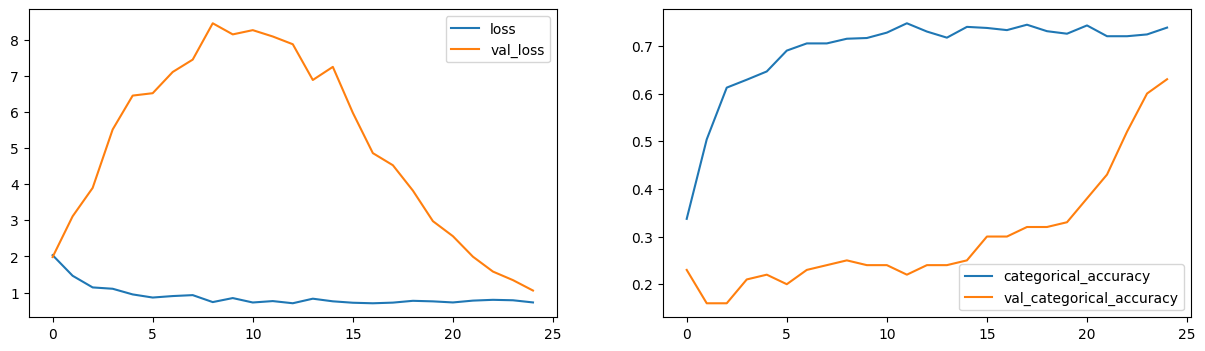

In [25]:
# Plot the training history of model10:
plot(history_model10)

### Model 11 with Augmentation:
### Adding more layers, Similar to model 4:

In [26]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
       
        model = Sequential()

        # 1st set of Convolutional and pooling layers:
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 2nd set of Convolutional and pooling layers:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 3rd set of Convolutional and pooling layers:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 4th set of Convolutional and pooling layers:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer:
        model.add(Flatten())

        # 1st Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # 2nd Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile model:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [27]:
# Instantiate ModelConv3D11:
conv_3d11 = ModelConv3D11()

# Initialize paths and image properties:
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
conv_3d11.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=25)

# Define and compile the model:
conv_3d11_model = conv_3d11.define_model(filtersize=(3, 3, 3), dense_neurons=256, dropout=0.5)

# Display model summary:
conv_3d11_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 16, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_15 (Conv3D)              │ (None, 8, 60, 60, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_16 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 4, 30, 30, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [28]:
# Print total parameters of the model:
print("Total Params:", conv_3d11_model.count_params())

# Train the model and store the training history:
history_model11 = conv_3d11.train_model(conv_3d11_model, augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2869 - loss: 2.3502
Epoch 1: saving model to model_init_2024-04-2501_32_18.879782/model-00001-2.22564-0.31750-1.98922-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 294s 9s/step - categorical_accuracy: 0.2878 - loss: 2.3467 - val_categorical_accuracy: 0.1600 - val_loss: 1.9892 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4227 - loss: 1.7148
Epoch 2: saving model to model_init_2024-04-2501_32_18.879782/model-00002-1.73361-0.43741-2.92277-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 284s 8s/step - categorical_accuracy: 0.4231 - loss: 1.7153 - val_categorical_accuracy: 0.1600 - val_loss: 2.9228 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.5108 - loss: 1.4909
Epoch 3: saving model to model_init_2024-04-2501_32_18.879782/model-00003-1.49141-0.50528-3.83268-0.21000.keras
34/34 ━━━━━━━━━━━━━━━

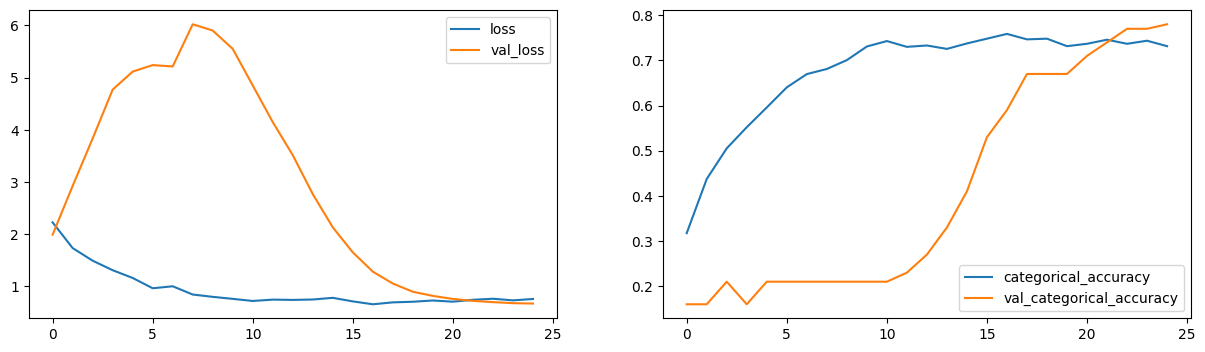

In [29]:
# Plot the training history of model11:
plot(history_model11)

### Model 12 with Augmentation:
### Adding dropouts, Similar to Model 5:

In [30]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        
        model = Sequential()

        # 1st set of Convolutional and pooling layers:
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # 2nd set of Convolutional and pooling layers:
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # 3rd set of Convolutional and pooling layers:
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # 4th set of Convolutional and pooling layers:
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # Flatten layer:
        model.add(Flatten())

        # 1st Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # 2nd Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile model:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [31]:
# Instantiate ModelConv3D12:
conv_3d12 = ModelConv3D12()

# Initialize paths and image properties:
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
conv_3d12.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=25)

# Define and compile the model:
conv_3d12_model = conv_3d12.define_model(filtersize=(3, 3, 3), dense_neurons=256, dropout=0.25)

# Display model summary:
conv_3d12_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_21 (Conv3D)              │ (None, 16, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_22 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_23 (Conv3D)              │ (None, 8, 60, 60, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_24 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_25 (Conv3D)              │ (None, 4, 30, 30, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [32]:
# Print total parameters of the model:
print("Total Params:", conv_3d12_model.count_params())

# Train the model and store the training history:
history_model12 = conv_3d12.train_model(conv_3d12_model, augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2613 - loss: 2.2108
Epoch 1: saving model to model_init_2024-04-2503_32_23.543841/model-00001-2.03965-0.29713-2.29573-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 299s 9s/step - categorical_accuracy: 0.2623 - loss: 2.2059 - val_categorical_accuracy: 0.2100 - val_loss: 2.2957 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3925 - loss: 1.6876
Epoch 2: saving model to model_init_2024-04-2503_32_23.543841/model-00002-1.60867-0.42308-3.95762-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 286s 8s/step - categorical_accuracy: 0.3934 - loss: 1.6853 - val_categorical_accuracy: 0.2100 - val_loss: 3.9576 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4694 - loss: 1.4653
Epoch 3: saving model to model_init_2024-04-2503_32_23.543841/model-00003-1.37073-0.50226-5.48863-0.21000.keras
34/34 ━━━━━━━━━━━━━━━

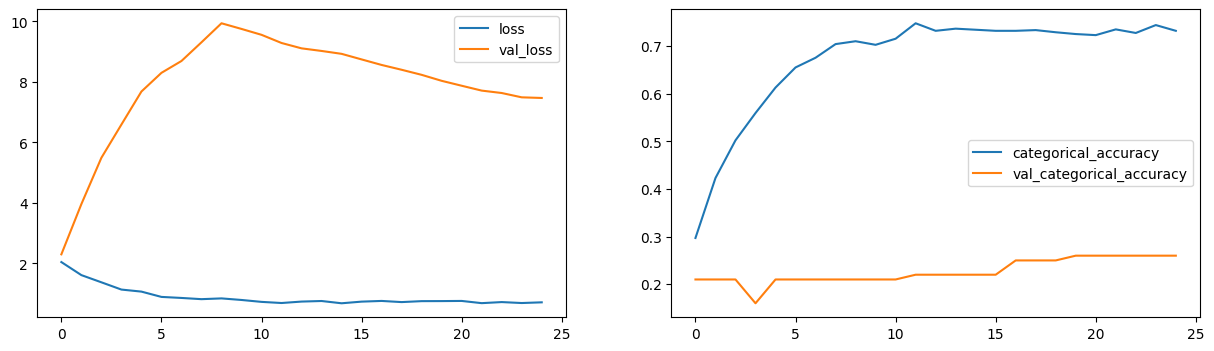

In [33]:
# Plot the training history of model12:
plot(history_model12)

### Observations: The model is experiencing significant overfitting.

### Model 13 with Augmentation:
### Reducing network parameters, Similar to Model 6:

In [34]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self, dense_neurons=64, dropout=0.25):
      
        model = Sequential()

        # 1st Convolutional and pooling layers:
        model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 2nd Convolutional and pooling layers:
        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 3rd Convolutional and pooling layers:
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 4th Convolutional and pooling layers:
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Flatten layer:
        model.add(Flatten())

        # 1st Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # 2nd Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile model:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [35]:
# Instantiate ModelConv3D13:
conv_3d13 = ModelConv3D13()

# Initialize paths and image properties:
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100, image_width=100)

# Initialize hyperparameters:
conv_3d13.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=25)

# Define and compile the model:
conv_3d13_model = conv_3d13.define_model(dense_neurons=128, dropout=0.25)

# Display model summary:
conv_3d13_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)              │ (None, 16, 100, 100,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 16, 100, 100,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 100, 100,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_20 (MaxPooling3D) │ (None, 8, 50, 50, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 8, 50, 50, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 8, 50, 50, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 8, 50, 50, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_21 (MaxPooling3D) │ (None, 4, 25, 25, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_30 (Conv3D)              │ (None, 4, 25, 25, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 4, 25, 25, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 4, 25, 25, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 2, 12, 12, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 2, 12, 12, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 2, 12, 12, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 2, 12, 12, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 1, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 696,645 (2.66 MB)

 Trainable params: 695,653 (2.65 MB)

 Non-trainable params: 992 (3.88 KB)

In [36]:
# Print total parameters of the model:
print("Total Params:", conv_3d13_model.count_params())

# Train the model and store the training history:
history_model13 = conv_3d13.train_model(conv_3d13_model, augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3115 - loss: 1.9384
Epoch 1: saving model to model_init_2024-04-2505_32_08.347543/model-00001-1.70632-0.37934-2.02142-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - categorical_accuracy: 0.3134 - loss: 1.9318 - val_categorical_accuracy: 0.2100 - val_loss: 2.0214 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.5447 - loss: 1.1755
Epoch 2: saving model to model_init_2024-04-2505_32_08.347543/model-00002-1.08774-0.57994-2.67461-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - categorical_accuracy: 0.5457 - loss: 1.1730 - val_categorical_accuracy: 0.2100 - val_loss: 2.6746 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.6563 - loss: 0.8839
Epoch 3: saving model to model_init_2024-04-2505_32_08.347543/model-00003-0.86317-0.67873-3.61302-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━

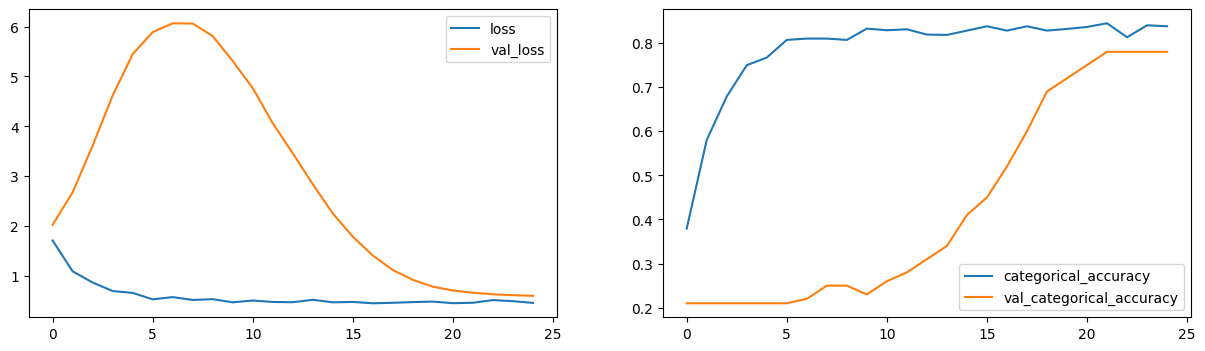

In [37]:
# Plot the training history of model13:
plot(history_model13)

### Model 14 with Augmentation:
### Reducing network parameters again, Similar to model 7:

In [38]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self, dense_neurons=64, dropout=0.25):
       
        model = Sequential()

        # 1st Convolutional and pooling layers:
        model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 2nd Convolutional and pooling layers:
        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 3rd Convolutional and pooling layers:
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # 4th Convolutional and pooling layers:
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Flatten layer:
        model.add(Flatten())

        # 1st Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # 2nd Dense Layer:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile model:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [39]:
# Instantiate ModelConv3D14:
conv_3d14 = ModelConv3D14()

# Initialize paths and image properties:
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
conv_3d14.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=25)

# Define and compile the model:
conv_3d14_model = conv_3d14.define_model(dense_neurons=64, dropout=0.25)

# Display model summary:
conv_3d14_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_32 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_24 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_33 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_25 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_34 (Conv3D)              │ (None, 4, 30, 30, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_26 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_35 (Conv3D)              │ (None, 2, 15, 15, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 504,709 (1.93 MB)

 Trainable params: 503,973 (1.92 MB)

 Non-trainable params: 736 (2.88 KB)

In [40]:
# Print total parameters of the model:
print("Total Params:", conv_3d14_model.count_params())

# Train the model and store the training history:
history_model14 = conv_3d14.train_model(conv_3d14_model, augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2603 - loss: 1.9840
Epoch 1: saving model to model_init_2024-04-2506_37_27.566282/model-00001-1.73999-0.34465-1.84092-0.20000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - categorical_accuracy: 0.2627 - loss: 1.9771 - val_categorical_accuracy: 0.2000 - val_loss: 1.8409 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5420 - loss: 1.2035
Epoch 2: saving model to model_init_2024-04-2506_37_27.566282/model-00002-1.13899-0.56033-2.77732-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 190s 6s/step - categorical_accuracy: 0.5425 - loss: 1.2017 - val_categorical_accuracy: 0.1600 - val_loss: 2.7773 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.6370 - loss: 0.9634
Epoch 3: saving model to model_init_2024-04-2506_37_27.566282/model-00003-0.99718-0.63424-3.62752-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━

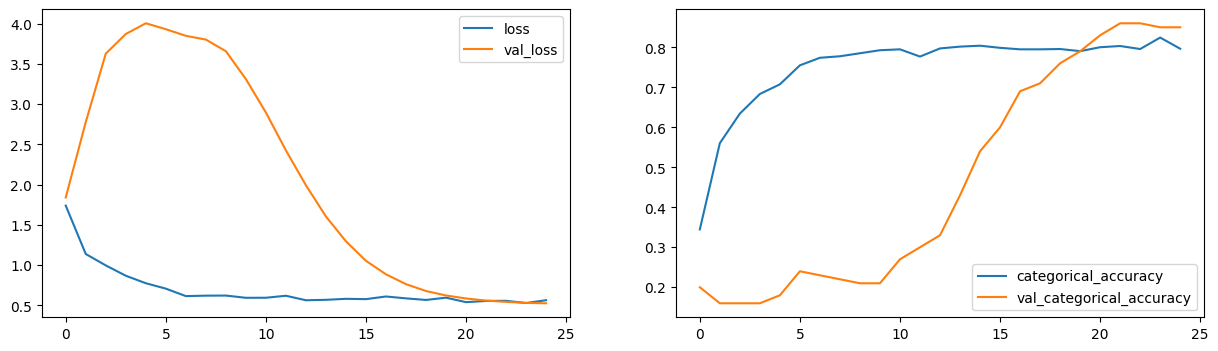

In [41]:
# Plot the training history of model14:
plot(history_model14)

### Model 15 with Augmentation:
### CNN LSTM with GRU, Similar to Model 8:

In [42]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
       
        model = Sequential()

        # 1st TimeDistributed Convolutional and pooling layers:
        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # 2nd TimeDistributed Convolutional and pooling layers:
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # 3rd TimeDistributed Convolutional and pooling layers:
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # 4th TimeDistributed Convolutional and pooling layers:
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        # GRU layer:
        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        # Dense layers:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile model:
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [43]:
# Instantiate RNNCNN2:
rnn_cnn2 = RNNCNN2()

# Initialize paths and image properties:
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
rnn_cnn2.initialize_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=20)

# Define and compile the model:
rnn_cnn2_model = rnn_cnn2.define_model(lstm_cells=128, dense_neurons=128, dropout=0.25)

# Display model summary:
rnn_cnn2_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 18, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 18, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 18, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 18, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 18, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 18, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 18, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 18, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 18, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 18, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 18, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 18, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 18, 6272)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │     2,458,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,573,925 (9.82 MB)

 Trainable params: 2,573,445 (9.82 MB)

 Non-trainable params: 480 (1.88 KB)

In [44]:
# Print total parameters of the model:
print("Total Params:", rnn_cnn2_model.count_params())

# Train the model and store the training history:
history_model15 = rnn_cnn2.train_model(rnn_cnn2_model, augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - categorical_accuracy: 0.3357 - loss: 1.5785 
Epoch 1: saving model to model_init_2024-04-2507_57_33.184898/model-00001-1.37581-0.41101-1.00144-0.58000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1453s 42s/step - categorical_accuracy: 0.3378 - loss: 1.5727 - val_categorical_accuracy: 0.5800 - val_loss: 1.0014 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - categorical_accuracy: 0.6191 - loss: 0.9776 
Epoch 2: saving model to model_init_2024-04-2507_57_33.184898/model-00002-0.93844-0.62670-0.79089-0.69000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1470s 43s/step - categorical_accuracy: 0.6193 - loss: 0.9765 - val_categorical_accuracy: 0.6900 - val_loss: 0.7909 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - categorical_accuracy: 0.7743 - loss: 0.6869 
Epoch 3: saving model to model_init_2024-04-2507_57_33.184898/model-00003-0.73381-0.75264-0.71164-0.74000.keras
34/34 ━━━━━

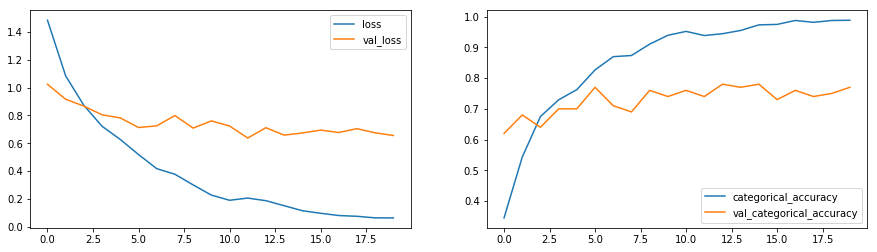

In [ ]:
# Plot the training history of model15:
plot(history_model15)

### Observations: We've noticed a substantial increase in overfitting with more augmentation. However, we're not seeing much of an improvement in accuracy.

### Model 16:
### How about we integrate Transfer Learning?
__(Optional)__

In [15]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [16]:
# Load MobileNet model pre-trained on ImageNet:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        """
        Define the architecture of the RNN-CNN Transfer Learning model using MobileNet as feature extractor.

        Args:
            lstm_cells: Number of LSTM cells.
            dense_neurons: Number of neurons in dense layers.
            dropout: Dropout rate."""

        model = Sequential()

        # Add MobileNet as TimeDistributed layer:
        model.add(TimeDistributed(mobilenet_transfer, input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))

        # Freeze MobileNet layers:
        for layer in model.layers:
            layer.trainable = False

        # Additional layers:
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        # LSTM layer:
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        # Dense layers:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile model:
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model


In [17]:
# Instantiate RNNCNN_TL:
rnn_cnn_tl = RNNCNN_TL()

# Initialize paths and image properties:
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16, batch_size=5, num_epochs=20)

# Define and compile the model:
rnn_cnn_tl_model = rnn_cnn_tl.define_model(lstm_cells=128, dense_neurons=128, dropout=0.25)

# Display model summary:
rnn_cnn_tl_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [18]:
# Print total parameters of the model:
print("Total Params:", rnn_cnn_tl_model.count_params())

# Train the model and store the training history:
history_model16 = rnn_cnn_tl.train_model(rnn_cnn_tl_model, augment_data=True)

Total Params: 3228864
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3685 - loss: 1.4628
Epoch 1: saving model to model_init_2024-04-2519_43_07.068536/model-00001-1.28018-0.46757-0.77380-0.74000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - categorical_accuracy: 0.3693 - loss: 1.4614 - val_categorical_accuracy: 0.7400 - val_loss: 0.7738 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6469 - loss: 0.9327
Epoch 2: saving model to model_init_2024-04-2519_43_07.068536/model-00002-0.84179-0.68024-0.69373-0.74000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - categorical_accuracy: 0.6471 - loss: 0.9320 - val_categorical_accuracy: 0.7400 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.7901 - loss: 0.6047
Epoch 3: saving model to model_init_2024-04-2519_43_07.068536/model-00003-0.57015-0.79713-0.61902-0.77000.keras
133/133 ━━━━━━━━━━━

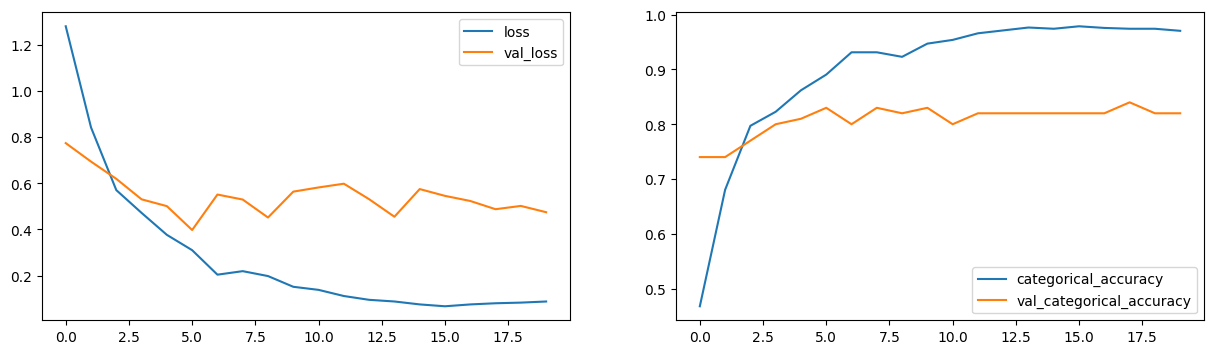

In [19]:
# Plot the training history of model16:
plot(history_model16)

### Observations: Since we're not training the MobileNet weights, we're encountering poor validation accuracy. Let's include training them and assess if it enhances performance.

### Model 17:
### Transfer Learning with GRU and training all weights:
__(Optional)__

In [20]:
from keras.applications import mobilenet

# Load MobileNet model pre-trained on ImageNet:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self, gru_cells=64, dense_neurons=64, dropout=0.25):
        """
        Define the architecture of the RNN-CNN Transfer Learning model using MobileNet as feature extractor
        and GRU as the recurrent layer.

        Args:
            gru_cells (int): Number of GRU cells.
            dense_neurons (int): Number of neurons in dense layers.
            dropout (float): Dropout rate. """
       
        model = Sequential()

        # Add MobileNet as TimeDistributed layer:
        model.add(TimeDistributed(mobilenet_transfer, input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))

        # Additional layers:
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        # GRU layer:
        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        # Dense layers:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        # Output layer:
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile model:
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [21]:
# Instantiate RNNCNN_TL2:
rnn_cnn_tl2 = RNNCNN_TL2()

# Initialize paths and image properties:
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters:
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16, batch_size=5, num_epochs=20)

# Define and compile the model:
rnn_cnn_tl2_model = rnn_cnn_tl2.define_model(gru_cells=128, dense_neurons=128, dropout=0.25)

# Display model summary:
rnn_cnn_tl2_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [22]:
# Print total parameters of the model:
print("Total Params:", rnn_cnn_tl2_model.count_params())

# Train the model and store the training history:
history_model17 = rnn_cnn_tl2.train_model(rnn_cnn_tl2_model, augment_data=True)

Total Params: 3228864
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.5286 - loss: 1.2085
Epoch 1: saving model to model_init_2024-04-2520_49_34.176017/model-00001-0.96641-0.63876-0.41897-0.85000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 635s 4s/step - categorical_accuracy: 0.5294 - loss: 1.2067 - val_categorical_accuracy: 0.8500 - val_loss: 0.4190 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7530 - loss: 0.7034
Epoch 2: saving model to model_init_2024-04-2520_49_34.176017/model-00002-0.71507-0.74736-0.48448-0.85000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 556s 4s/step - categorical_accuracy: 0.7530 - loss: 0.7035 - val_categorical_accuracy: 0.8500 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.8410 - loss: 0.4780
Epoch 3: saving model to model_init_2024-04-2520_49_34.176017/model-00003-0.44296-0.86275-0.21526-0.93000.keras
133/133 ━━━━━━━━━━━

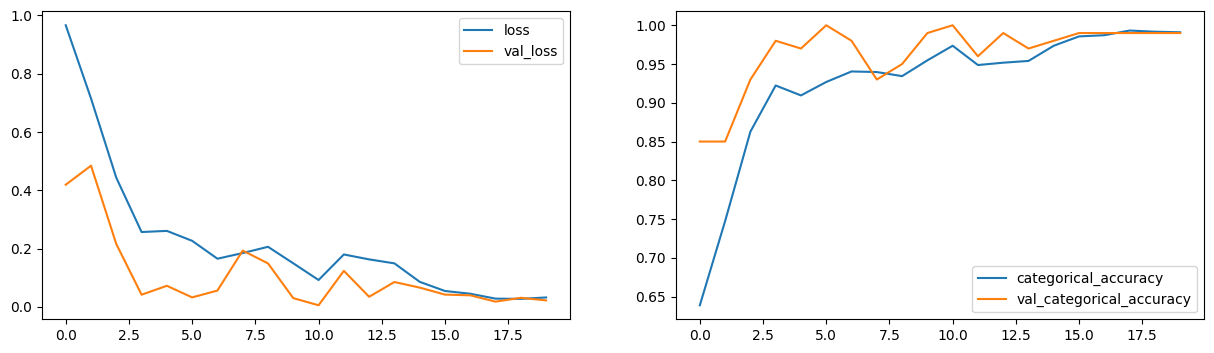

In [23]:
# Plot the training history of model17:
plot(history_model17)

### Observations: Achieving a training accuracy of 99% and a validation accuracy of 99% is truly remarkable!

### Conclusion: After conducting extensive experiments, we can conclude that Model 8, utilizing a combination of CNN and LSTM, exhibited strong performance. So we can select it as our final selection.

- Model 8 achieves a commendable Training Accuracy of 98% and Validation Accuracy of 89%, indicating its capability to generalize well to unseen data.

- Model 8 has fewer parameters compared to other models, while maintaining strong performance.

- The optimal weights for the CNN-LSTM model are stored in file "model-00017-0.09221-0.97813-0.27520-0.89000" . These weights were utilized for testing the model's performance. Let's check out how well it's performing.

### Loading Model and Testing:

In [23]:
from keras.models import load_model

# Load the model from .keras file
model = load_model("C:/Users/shish/Desktop/geture/Project_data/model_init_2024-04-2606_44_18.112538/model-00017-0.09221-0.97813-0.27520-0.89000.keras", compile=False)

# Save the model to .h5 file
model.save("C:/Users/shish/Desktop/geture/Project_data/model_init_2024-04-2606_44_18.112538/model-00017-0.09221-0.97813-0.27520-0.89000.keras.h5")


In [24]:
# Instantiate the test generator:
test_generator = RNNCNN1()

# Initialize paths and image properties for the test generator:
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120, image_width=120)

# Initialize hyperparameters for the test generator:
test_generator.initialize_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=20)

# Generate a batch of data and labels for testing:
# The generator is initialized with validation data and set to not perform data augmentation:
g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=False)
batch_data, batch_labels = next(g)


In [25]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [26]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0 2 2 2 1 4 3 4 1 2 0 3 2 2 4 1 1 3 4 3]


### Technologies Used:
- Python, version 3 
- NumPy for numerical computations
- Matplotlib and seaborn for data visualization
- Pandas for data manipulation
- Statsmodels for statistical modeling
- Sklearn for machine learning tasks
- Tensorflow, keras, augmentor for deep learning 
- Jupyter Notebook for interactive analysis

### References:
- Python documentations
- Tensorflow, keras, augmentor documentations
- Stack Overflow

### Contact Information:
Created by https://github.com/Erkhanal - feel free to contact!
#### *Msc, ML&AI*